# Size vs error analysis

In [1]:
using PyPlot, FileIO, JLD2, Statistics

path = "/network/aopp/chaos/pred/kloewer/esowc/"
@load joinpath(path,"analysis","compress_errors.jld2") varnames E C

3-element Vector{Symbol}:
 :varnames
 :E
 :C

In [10]:
weirdos = ["aergn02","aergn07","aergn09","cc","ciwc","clwc","cswc","crwc"]
sort_out = [~(v in weirdos) for v in varnames]

# replace weirdos with round+lossless (FALLBACK)
C[.~sort_out,5] = C[.~sort_out,3]
C[.~sort_out,6] = C[.~sort_out,4];

# for data output
# E[.~sort_out,5,:,:] .= E[.~sort_out,3,:,:]
# E[.~sort_out,6,:,:] .= E[.~sort_out,4,:,:];

# for plotting (don't plot twice)
E[.~sort_out,5,:,:] .= 0
E[.~sort_out,6,:,:] .= 0;

In [11]:
## geometric mean
geometric_mean(x::Vector) = inv(mean(inv.(x)))

gm_lin24 = geometric_mean([c for c in C[:,1] if c > 0])
gm_log16 = geometric_mean([c for c in C[:,2] if c > 0])
gm_rl100 = geometric_mean([c for c in C[:,3] if c > 0])
gm_rl99 = geometric_mean([c for c in C[:,4] if c > 0])
gm_zfp100 = geometric_mean([c for c in C[:,5] if c > 0])
gm_zfp99 = geometric_mean([c for c in C[:,6] if c > 0])
                                                                                               
gm_lin24 = 64/24
gm_log16 = 4;                                                                                

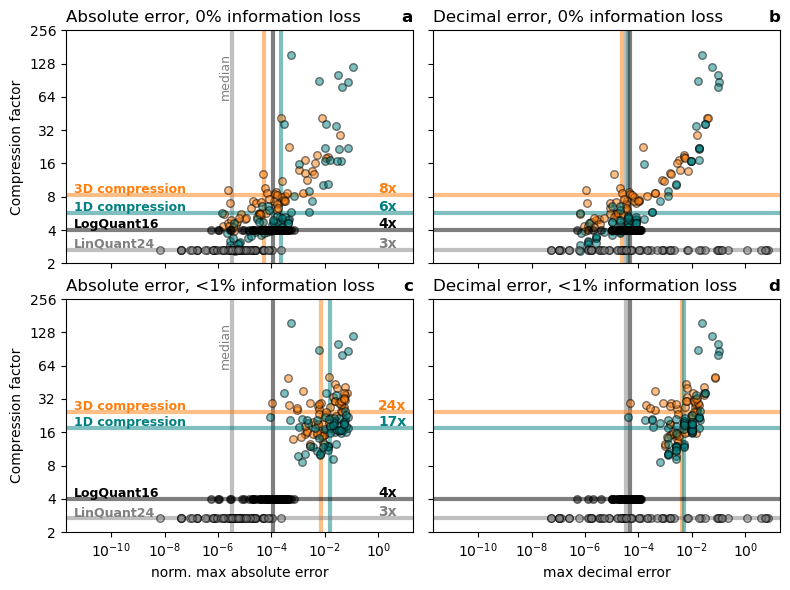

In [12]:
## plotting
fig,(ax1,ax3,ax2,ax4) = subplots(2,2,figsize=(8,6),sharex=true,sharey=true)

colours = ["grey","k","teal","teal","C1","C1"]
labls = ["LinQuant24",
            "LogQuant16",
            "1D compression",
            "1D compression",
            "3D compression",
            "3D compression"]

# options
alfa  = 0.5
alfa2 = 0.5

ymax = 256
ymin = 2
xmax = 2e1
xmin = 2e-12

q = 5    # 1=median,2=67th percentile,3=90th,4=95th,5=max
s = 30

# ABSOLUTE ERROR
for i in reverse(1:size(E)[2])
    if i in [1,2,3,5]
        ax1.scatter(E[:,i,1,q],log2.(C[:,i]),s,colours[i],alpha=alfa,edgecolor="k")
        ax1.axvline(median(E[:,i,1,q]),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
        if i == 1
            for ax in [ax1,ax3]
                ax.text(median(E[:,i,1,q]),log2(ymax/4),
                "median",color=colours[i],rotation=90,ha="right",fontsize=9)
            end
        end
    end
    if i in [1,2,4,6]
        ax3.scatter(E[:,i,1,q],log2.(C[:,i]),s,colours[i],alpha=alfa,edgecolor="k")
        ax3.axvline(median(E[:,i,1,q]),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
    end
end

# DECIMAL ERROR
for i in reverse(1:size(E)[2])
    if i in [1,2,3,5]
        ax2.scatter(E[:,i,2,q],log2.(C[:,i]),s,colours[i],alpha=alfa,edgecolor="k")
        ax2.axvline(median(E[:,i,2,q]),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
    end
    if i in [1,2,4,6]
        ax4.scatter(E[:,i,2,q],log2.(C[:,i]),s,colours[i],alpha=alfa,edgecolor="k")
        ax4.axvline(median(E[:,i,2,q]),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
    end
end

ytiks = collect(log2(ymin):log2(ymax))

for ax in [ax1,ax2,ax3,ax4]
    ax.set_yticks(ytiks)
    ax.set_xscale("log")
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(log2(ymin),log2(ymax))
end

ax1.set_yticklabels([Int(2 .^i) for i in ytiks])
ax3.set_yticklabels([Int(2 .^i) for i in ytiks])

ax1.set_title("Absolute error, 0% information loss",loc="left")
ax2.set_title("Decimal error, 0% information loss",loc="left")
ax3.set_title("Absolute error, <1% information loss",loc="left")
ax4.set_title("Decimal error, <1% information loss",loc="left")

ax3.set_xlabel("norm. max absolute error")
ax4.set_xlabel("max decimal error")
ax1.set_ylabel("Compression factor")
ax3.set_ylabel("Compression factor")

ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax3.set_title("c",loc="right",fontweight="bold")
ax4.set_title("d",loc="right",fontweight="bold")

for (i,gm) in enumerate([gm_lin24,gm_log16,gm_rl100,gm_rl99,gm_zfp100,gm_zfp99])
    if i in [1,2,3,5]
        ax1.axhline(log2(gm),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
        ax2.axhline(log2(gm),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
        ax1.text(xmax/20,log2(gm*1.04),string(round(Int,gm))*"x",color=colours[i],fontweight="bold")
        ax1.text(xmin*2,log2(gm*1.04),labls[i],color=colours[i],fontweight="bold",fontsize=9)
    end
    if i in [1,2,4,6]
        ax3.axhline(log2(gm),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
        ax4.axhline(log2(gm),color=colours[i],zorder=-1,lw=3,alpha=alfa2)
        ax3.text(xmax/20,log2(gm*1.04),string(round(Int,gm))*"x",color=colours[i],fontweight="bold")
        ax3.text(xmin*2,log2(gm*1.04),labls[i],color=colours[i],fontweight="bold",fontsize=9)
    end
end

tight_layout(h_pad=0.5)
savefig("compression_error.png",dpi=200)
savefig("compression_error.pdf")

# Output

In [5]:
using DataFrames, CSV

In [6]:
C_output = Float32.(C)
varnames_C = cat(varnames,C_output,dims=2)
cols = ["Variable","Lin24","Log16","1D 100%","1D 99%","3D 100%","3D 99%"]
df = DataFrame(varnames_C,cols)
CSV.write("Fig4_compressionfactor_data.csv",df)

"Fig4_compressionfactor_data.csv"

In [7]:
Edec_output = cat(varnames,Float32.(E[:,:,2,5]),dims=2)
df = DataFrame(Edec_output,cols)
CSV.write("Fig4_maxdecimalerrors_data.csv",df)

"Fig4_maxdecimalerrors_data.csv"

In [8]:
Eabs_output = cat(varnames,Float32.(E[:,:,1,5]),dims=2)
df = DataFrame(Eabs_output,cols)
CSV.write("Fig4_maxabserrors_data.csv",df)

"Fig4_maxabserrors_data.csv"